# MR3 vs Control Group Best Gene Set Clustering Analysis

This notebook implements an algorithm to select the optimal gene set for clustering MR3 and Control groups, using both UMAP and PCA dimensionality reduction methods, and evaluating with variance as the metric.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
import umap
import warnings
from itertools import combinations
import time
from scipy import stats

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 20)
warnings.filterwarnings('ignore')

# Set matplotlib Chinese display
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
def process_gbm_samples(files, group_names, gene_map, transpose=False):
    """
    Process GBM sample data
    """
    all_data = []
    for file in files:
        # Read each file into a DataFrame
        df = pd.read_csv(file, sep='\t', names=['gene_id', 'count'], dtype={'gene_id': str})
        df['count'] = pd.to_numeric(df['count'], errors='coerce')
        df['source'] = file
        all_data.append(df)
    
    # Combine all data into a single DataFrame
    combined = pd.concat(all_data)
    
    # Process gene mapping table
    gene_map = gene_map.iloc[:, :2]  # Keep only the first two columns
    gene_map.columns = ['gene_id', 'gene_name']  # Rename columns
    gene_map['gene_id'] = gene_map['gene_id'].astype(str)  # Convert gene_id to string
    gene_map['gene_name'] = gene_map['gene_name'].str.replace(' or ', '|', regex=False)  # Replace 'or' with '|'
    gene_map['gene_name'] = gene_map['gene_name'].str.split('|')  # Split gene names by '|'
    gene_map = gene_map.explode('gene_name')  # Expand gene names into multiple rows
    gene_map = gene_map.dropna(subset=['gene_name'])  # Remove rows with missing gene names
    gene_map = gene_map.drop_duplicates()  # Remove duplicate rows
    
    # Merge gene mapping information with combined data
    merged = pd.merge(combined, gene_map, on='gene_id', how='left')
    
    # Remove rows without gene names
    merged = merged.dropna(subset=['gene_name'])
    print(f"After removing rows without gene names: {len(merged)} rows remaining")
    
    # Create a pivot table with genes as rows and samples as columns
    pivoted = merged.pivot(index='gene_name', columns='source', values='count')
    pivoted = np.log2(pivoted + 1)
    
    # Add group labels for each sample
    sample_groups = {}
    for file, group in zip(files, group_names):
        sample_groups[file] = group

    # Separate samples into treated (MR3) and untreated (DMSO) groups
    treated_cols = [col for col in pivoted.columns if sample_groups[col] == 'MR3']
    untreated_cols = [col for col in pivoted.columns if sample_groups[col] in ['DMSO', 'Plain']]

    treated_df = pivoted[treated_cols]
    untreated_df = pivoted[untreated_cols]
    
    # Rename columns to extract sample names
    def extract_sample_name(file_path, group):
        import re
        match = re.search(r'\[(.*?)\]', file_path)
        if match:
            sample_info = match.group(1)
            sample_match = re.search(r'(W\d+)', sample_info)
            if sample_match:
                sample_id = sample_match.group(1)
                return f"{sample_id}_{group}"
        return file_path  # fallback to original if parsing fails
    
    # Create new column names for treated samples
    treated_new_cols = {}
    for col in treated_cols:
        treated_new_cols[col] = extract_sample_name(col, 'MR3')
    treated_df = treated_df.rename(columns=treated_new_cols)
    
    # Create new column names for untreated samples  
    untreated_new_cols = {}
    for col in untreated_cols:
        untreated_new_cols[col] = extract_sample_name(col, sample_groups[col])
    untreated_df = untreated_df.rename(columns=untreated_new_cols)
    
    if transpose:
        treated_df = treated_df.T
        untreated_df = untreated_df.T
    
    print(f"MR3 treated samples: {treated_df.shape}")
    print(f"Control untreated samples: {untreated_df.shape}")
    
    return treated_df, untreated_df

print("Data processing function definition completed!")

Data processing function definition completed!


In [3]:
# Data file paths and grouping information
gbm_files = [
    '/Users/duze/Desktop/WangLab/Data/BulkRNAseq/GalaxyData/Galaxy25-[W11_GBM_MR3].tabular',
    '/Users/duze/Desktop/WangLab/Data/BulkRNAseq/GalaxyData/Galaxy28-[W30_HG_MR3].tabular',
    '/Users/duze/Desktop/WangLab/Data/BulkRNAseq/GalaxyData/Galaxy30-[W28_LG_MR3].tabular',
    '/Users/duze/Desktop/WangLab/Data/BulkRNAseq/GalaxyData/Galaxy26-[W6_GBM_DMSO].tabular',
    '/Users/duze/Desktop/WangLab/Data/BulkRNAseq/GalaxyData/Galaxy27-[W27_LG_DMSO].tabular',
    '/Users/duze/Desktop/WangLab/Data/BulkRNAseq/GalaxyData/Galaxy29-[W29_HG_DMSO].tabular',
    '/Users/duze/Desktop/WangLab/Data/BulkRNAseq/GalaxyData/Galaxy42-[W1_Plain_Tissue].tabular'
]

gbm_groups = ['MR3']*3 + ['DMSO']*3 + ['Plain']*1

# Read gene mapping table
gbm_map = pd.read_excel('/Users/duze/Desktop/WangLab/Data/BulkRNAseq/GalaxyData/GeneID_Name.xlsx')

print("Starting to process GBM sample data...")
MR3_gbm, Control_gbm = process_gbm_samples(gbm_files, gbm_groups, gbm_map, transpose=True)

print("\n=== Data loading completed ===")
print(f"MR3 group data shape: {MR3_gbm.shape}")
print(f"Control group data shape: {Control_gbm.shape}")
print(f"Number of common genes: {len(set(MR3_gbm.columns) & set(Control_gbm.columns))}")

# Merge data for analysis
common_genes = list(set(MR3_gbm.columns) & set(Control_gbm.columns))
MR3_data = MR3_gbm[common_genes]
Control_data = Control_gbm[common_genes]

# Create labels
MR3_labels = ['MR3'] * len(MR3_data)
Control_labels = ['Control'] * len(Control_data)

# Merge all data
all_data = pd.concat([MR3_data, Control_data], axis=0)
all_labels = MR3_labels + Control_labels

print(f"\nMerged data shape: {all_data.shape}")
print(f"Number of labels: {len(all_labels)}")
print(f"MR3 samples: {len(MR3_labels)}, Control samples: {len(Control_labels)}")

Starting to process GBM sample data...
After removing rows without gene names: 166103 rows remaining
MR3 treated samples: (3, 23729)
Control untreated samples: (4, 23729)

=== Data loading completed ===
MR3 group data shape: (3, 23729)
Control group data shape: (4, 23729)
Number of common genes: 23729

Merged data shape: (7, 23729)
Number of labels: 7
MR3 samples: 3, Control samples: 4
MR3 treated samples: (3, 23729)
Control untreated samples: (4, 23729)

=== Data loading completed ===
MR3 group data shape: (3, 23729)
Control group data shape: (4, 23729)
Number of common genes: 23729

Merged data shape: (7, 23729)
Number of labels: 7
MR3 samples: 3, Control samples: 4


In [4]:
class BestGeneSetSelector:
    """
    Best gene set selector class
    Uses UMAP and PCA for dimensionality reduction, with variance as evaluation metric
    """
    
    def __init__(self, mr3_data, control_data):
        self.mr3_data = mr3_data
        self.control_data = control_data
        self.common_genes = list(set(mr3_data.columns) & set(control_data.columns))
        self.all_data = pd.concat([mr3_data[self.common_genes], control_data[self.common_genes]], axis=0)
        self.labels = ['MR3'] * len(mr3_data) + ['Control'] * len(control_data)
        self.scaler = StandardScaler()
        
    def filter_genes_by_variance(self, variance_threshold=0.1):
        """Filter genes by variance"""
        gene_variances = self.all_data.var()
        high_var_genes = gene_variances[gene_variances > variance_threshold].index.tolist()
        print(f"Genes remaining after variance threshold {variance_threshold} filtering: {len(high_var_genes)}")
        return high_var_genes
    
    def filter_genes_by_differential_expression(self, fold_change_threshold=1.5, p_value_threshold=0.05):
        """Filter genes by differential expression"""
        mr3_mean = self.mr3_data[self.common_genes].mean()
        control_mean = self.control_data[self.common_genes].mean()
        
        # Calculate fold change
        fold_change = mr3_mean / control_mean
        
        # Perform t-test
        p_values = []
        for gene in self.common_genes:
            mr3_values = self.mr3_data[gene].values
            control_values = self.control_data[gene].values
            try:
                _, p_val = stats.ttest_ind(mr3_values, control_values)
                p_values.append(p_val)
            except:
                p_values.append(1.0)
        
        p_values = pd.Series(p_values, index=self.common_genes)
        
        # Screen differentially expressed genes
        de_genes = []
        for gene in self.common_genes:
            if (fold_change[gene] > fold_change_threshold or fold_change[gene] < 1/fold_change_threshold) and p_values[gene] < p_value_threshold:
                de_genes.append(gene)
        
        print(f"Differentially expressed genes (FC>{fold_change_threshold}, p<{p_value_threshold}): {len(de_genes)}")
        return de_genes
    
    def evaluate_gene_set_pca(self, gene_set, n_components=2):
        """Evaluate gene set using PCA, focusing on intra-group clustering"""
        if len(gene_set) < n_components:
            return 0, 0, 0, 0, 0
            
        # Prepare data
        data_subset = self.all_data[gene_set]
        data_scaled = self.scaler.fit_transform(data_subset)
        
        # PCA dimensionality reduction
        pca = PCA(n_components=n_components)
        pca_result = pca.fit_transform(data_scaled)
        
        # Calculate total explained variance ratio
        total_variance = np.sum(pca.explained_variance_ratio_)
        
        # Calculate MR3 and Control group data separately
        mr3_indices = list(range(len(self.mr3_data)))
        control_indices = list(range(len(self.mr3_data), len(self.all_data)))
        
        mr3_pca = pca_result[mr3_indices]
        control_pca = pca_result[control_indices]
        
        # Calculate intra-group clustering (smaller variance means better clustering)
        mr3_intra_variance = np.var(mr3_pca, axis=0).sum()
        control_intra_variance = np.var(control_pca, axis=0).sum()
        
        # Calculate inter-group distance (distance between center points)
        mr3_center = np.mean(mr3_pca, axis=0)
        control_center = np.mean(control_pca, axis=0)
        inter_group_distance = np.linalg.norm(mr3_center - control_center)
        
        # Calculate intra-group clustering score (1/variance, smaller variance = higher score)
        mr3_cohesion = 1 / (1 + mr3_intra_variance)  # Avoid division by zero
        control_cohesion = 1 / (1 + control_intra_variance)
        
        return total_variance, mr3_cohesion, control_cohesion, inter_group_distance, (mr3_intra_variance, control_intra_variance)
    
    def evaluate_gene_set_umap(self, gene_set, n_components=2):
        """Evaluate gene set using UMAP, focusing on intra-group clustering and inter-group separation"""
        if len(gene_set) < 10:  # UMAP requires sufficient features
            return 0, 0, 0, 0
            
        # Prepare data
        data_subset = self.all_data[gene_set]
        data_scaled = self.scaler.fit_transform(data_subset)
        
        # UMAP dimensionality reduction
        try:
            umap_model = umap.UMAP(n_components=n_components, random_state=42, n_neighbors=min(5, len(data_scaled)-1))
            umap_result = umap_model.fit_transform(data_scaled)
            
            # Calculate silhouette coefficient
            silhouette = silhouette_score(umap_result, self.labels)
            
            # Calculate MR3 and Control group data separately
            mr3_indices = list(range(len(self.mr3_data)))
            control_indices = list(range(len(self.mr3_data), len(self.all_data)))
            
            mr3_umap = umap_result[mr3_indices]
            control_umap = umap_result[control_indices]
            
            # Calculate intra-group clustering (standard deviation of intra-group distances, smaller = better clustering)
            mr3_intra_distances = []
            for i in range(len(mr3_umap)):
                for j in range(i+1, len(mr3_umap)):
                    dist = np.linalg.norm(mr3_umap[i] - mr3_umap[j])
                    mr3_intra_distances.append(dist)
            
            control_intra_distances = []
            for i in range(len(control_umap)):
                for j in range(i+1, len(control_umap)):
                    dist = np.linalg.norm(control_umap[i] - control_umap[j])
                    control_intra_distances.append(dist)
            
            # Intra-group clustering score (smaller distance standard deviation is better)
            mr3_cohesion = 1 / (1 + np.std(mr3_intra_distances)) if mr3_intra_distances else 0
            control_cohesion = 1 / (1 + np.std(control_intra_distances)) if control_intra_distances else 0
            
            # Calculate inter-group separation (distance between center points)
            mr3_center = np.mean(mr3_umap, axis=0)
            control_center = np.mean(control_umap, axis=0)
            separation = np.linalg.norm(mr3_center - control_center)
            
            return silhouette, mr3_cohesion, control_cohesion, separation
        except:
            return 0, 0, 0, 0
    
    def select_best_gene_sets(self, gene_pool, set_sizes=[1000, 5000, 10000, 15000], n_random_sets=5):
        """Select best gene sets, focusing on intra-group clustering"""
        results = []
        
        print("Starting gene set evaluation...")
        print(f"Gene pool size: {len(gene_pool)}")
        
        for set_size in set_sizes:
            if set_size > len(gene_pool):
                print(f"Skipping size {set_size}, gene pool only has {len(gene_pool)} genes")
                continue
                
            print(f"\nEvaluating gene set size: {set_size}")
            
            # Variance-based gene set
            gene_variances = self.all_data[gene_pool].var()
            top_var_genes = gene_variances.nlargest(set_size).index.tolist()
            
            # Differential expression-based gene set (if sufficient DE genes available)
            mr3_mean = self.mr3_data[gene_pool].mean()
            control_mean = self.control_data[gene_pool].mean()
            fold_change = mr3_mean / control_mean
            
            # Select genes with highest fold change
            if set_size <= len(gene_pool):
                abs_fold_change = np.abs(np.log2(fold_change))
                top_de_genes = abs_fold_change.nlargest(set_size).index.tolist()
            else:
                top_de_genes = gene_pool[:set_size]
            
            # Evaluate gene sets
            methods_and_genes = [
                ('high_variance', top_var_genes),
                ('differential_expression', top_de_genes)
            ]
            
            # Add random gene sets
            for i in range(n_random_sets):
                random_genes = np.random.choice(gene_pool, set_size, replace=False).tolist()
                methods_and_genes.append((f'random_{i+1}', random_genes))
            
            for method, genes in methods_and_genes:
                # PCA evaluation
                total_var, mr3_cohesion_pca, control_cohesion_pca, inter_distance_pca, variances = self.evaluate_gene_set_pca(genes)
                
                # UMAP evaluation
                silhouette, mr3_cohesion_umap, control_cohesion_umap, inter_distance_umap = self.evaluate_gene_set_umap(genes)
                
                # New scoring strategy: focus on intra-group clustering
                # Weights: intra-group clustering 70%, inter-group separation 20%, total variance 10%
                pca_score = (mr3_cohesion_pca + control_cohesion_pca) * 0.7 + inter_distance_pca * 0.2 + total_var * 0.1
                umap_score = (mr3_cohesion_umap + control_cohesion_umap) * 0.7 + inter_distance_umap * 0.2 + silhouette * 0.1
                
                # Composite score
                composite_score = pca_score * 0.6 + umap_score * 0.4
                
                results.append({
                    'set_size': set_size,
                    'method': method,
                    'genes': genes,
                    'pca_total_variance': total_var,
                    'pca_mr3_cohesion': mr3_cohesion_pca,
                    'pca_control_cohesion': control_cohesion_pca,
                    'pca_inter_distance': inter_distance_pca,
                    'pca_mr3_variance': variances[0],
                    'pca_control_variance': variances[1],
                    'umap_silhouette': silhouette,
                    'umap_mr3_cohesion': mr3_cohesion_umap,
                    'umap_control_cohesion': control_cohesion_umap,
                    'umap_inter_distance': inter_distance_umap,
                    'pca_score': pca_score,
                    'umap_score': umap_score,
                    'composite_score': composite_score
                })
                
                print(f"  {method} - PCA clustering score: {pca_score:.4f}, UMAP clustering score: {umap_score:.4f}, Composite score: {composite_score:.4f}")
        
        return pd.DataFrame(results)

print("BestGeneSetSelector class definition completed!")

BestGeneSetSelector class definition completed!


In [5]:
# Create gene set selector and use all genes
selector = BestGeneSetSelector(MR3_data, Control_data)

print("=== Gene Selection Analysis ===")
print(f"Total common genes: {len(selector.common_genes)}")

# Use ALL common genes for analysis (no filtering applied)
filtered_genes = selector.common_genes
print(f"Using ALL {len(filtered_genes)} common genes for analysis")
print(f"This represents 100% of total common genes")
print(f"Gene pool size for best gene set selection: {len(filtered_genes)}")

# Display some basic statistics about the gene pool
print(f"\nGene pool statistics:")
print(f"- Total genes available: {len(filtered_genes)}")
print(f"- Sample genes (first 10): {filtered_genes[:10]}")
print(f"- Will test gene set sizes from 1,000 up to all {len(filtered_genes)} genes")

=== Gene Selection Analysis ===
Total common genes: 23729
Using ALL 23729 common genes for analysis
This represents 100% of total common genes
Gene pool size for best gene set selection: 23729

Gene pool statistics:
- Total genes available: 23729
- Sample genes (first 10): ['ZNF616', 'MS4A4E', 'NIM1K', 'ENTPD3', 'SNORA16B', 'PLA2G4A', 'BLOC1S4', 'E2F8', 'OAZ1', 'MTHFD1L']
- Will test gene set sizes from 1,000 up to all 23729 genes


In [6]:
# Run best gene set selection using ALL GENES (no filtering)
print("\n=== Starting Best Gene Set Selection (ALL GENES) ===")
print(f"Gene pool: ALL {len(filtered_genes)} common genes (no filtering applied)")

# Use comprehensive gene set sizes, including all genes
gene_set_sizes = [1000, 5000, 10000]
if len(filtered_genes) > 15000:
    gene_set_sizes.append(15000)
if len(filtered_genes) > 20000:
    gene_set_sizes.append(20000)
if len(filtered_genes) > 25000:
    gene_set_sizes.append(25000)
# Always include the option to use ALL genes
gene_set_sizes.append(len(filtered_genes))

print(f"Testing gene set sizes: {gene_set_sizes}")

results_df = selector.select_best_gene_sets(
    gene_pool=filtered_genes,  # All common genes (no filtering)
    set_sizes=gene_set_sizes, 
    n_random_sets=3  # Reduce number of random sets to speed up computation
)

print("\n=== Gene Set Evaluation Results (ALL GENES POOL) ===")
print(results_df.round(4))


=== Starting Best Gene Set Selection (ALL GENES) ===
Gene pool: ALL 23729 common genes (no filtering applied)
Testing gene set sizes: [1000, 5000, 10000, 15000, 20000, 23729]
Starting gene set evaluation...
Gene pool size: 23729

Evaluating gene set size: 1000


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


  high_variance - PCA clustering score: 0.6266, UMAP clustering score: 0.8931, Composite score: 0.7332
  differential_expression - PCA clustering score: 5.5777, UMAP clustering score: 1.5371, Composite score: 3.9615
  random_1 - PCA clustering score: 2.1757, UMAP clustering score: 1.1008, Composite score: 1.7457
  random_2 - PCA clustering score: 2.1116, UMAP clustering score: 1.0558, Composite score: 1.6893
  random_3 - PCA clustering score: 2.1135, UMAP clustering score: 1.1261, Composite score: 1.7186

Evaluating gene set size: 5000
  high_variance - PCA clustering score: 0.6310, UMAP clustering score: 1.1496, Composite score: 0.8384
  differential_expression - PCA clustering score: 10.0922, UMAP clustering score: 1.3020, Composite score: 6.5761
  random_1 - PCA clustering score: 4.6595, UMAP clustering score: 0.9787, Composite score: 3.1871
  random_2 - PCA clustering score: 4.8143, UMAP clustering score: 1.1032, Composite score: 3.3299
  random_3 - PCA clustering score: 4.6239, UM

In [7]:
# Find the best gene set (selected from ALL genes)
best_geneset = results_df.loc[results_df['composite_score'].idxmax()]
print("\n=== Best Gene Set Information (Selected from ALL Genes) ===")
print(f"Size: {best_geneset['set_size']} genes")
print(f"Method: {best_geneset['method']}")
print(f"Selected from: ALL {len(selector.common_genes)} common genes (no pre-filtering)")
print(f"PCA total variance: {best_geneset['pca_total_variance']:.4f}")
print(f"PCA MR3 clustering: {best_geneset['pca_mr3_cohesion']:.4f}")
print(f"PCA Control clustering: {best_geneset['pca_control_cohesion']:.4f}")
print(f"PCA inter-group distance: {best_geneset['pca_inter_distance']:.4f}")
print(f"PCA MR3 variance: {best_geneset['pca_mr3_variance']:.4f} (smaller is better clustering)")
print(f"PCA Control variance: {best_geneset['pca_control_variance']:.4f} (smaller is better clustering)")
print(f"UMAP silhouette coefficient: {best_geneset['umap_silhouette']:.4f}")
print(f"UMAP MR3 clustering: {best_geneset['umap_mr3_cohesion']:.4f}")
print(f"UMAP Control clustering: {best_geneset['umap_control_cohesion']:.4f}")
print(f"UMAP inter-group distance: {best_geneset['umap_inter_distance']:.4f}")
print(f"Composite score: {best_geneset['composite_score']:.4f}")

# Get the best gene list
best_genes = best_geneset['genes']
print(f"\nBest gene set contains {len(best_genes)} genes")
print(f"This represents {len(best_genes)/len(selector.common_genes)*100:.1f}% of ALL {len(selector.common_genes)} common genes")
print("First 10 genes:", best_genes[:10])

# Show clustering effect summary
print(f"\n=== Clustering Effect Summary (Best from ALL Genes) ===")
print(f"MR3 group clustering effect - PCA clustering: {best_geneset['pca_mr3_cohesion']:.4f}, UMAP clustering: {best_geneset['umap_mr3_cohesion']:.4f}")
print(f"Control group clustering effect - PCA clustering: {best_geneset['pca_control_cohesion']:.4f}, UMAP clustering: {best_geneset['umap_control_cohesion']:.4f}")
print(f"Inter-group separation effect - PCA distance: {best_geneset['pca_inter_distance']:.4f}, UMAP distance: {best_geneset['umap_inter_distance']:.4f}")

# Compare with using all genes
if len(best_genes) == len(selector.common_genes):
    print(f"\n🎯 The best gene set uses ALL {len(selector.common_genes)} genes!")
else:
    print(f"\n📊 The best gene set uses {len(best_genes)} out of {len(selector.common_genes)} genes ({len(best_genes)/len(selector.common_genes)*100:.1f}%)")


=== Best Gene Set Information (Selected from ALL Genes) ===
Size: 10000 genes
Method: differential_expression
Selected from: ALL 23729 common genes (no pre-filtering)
PCA total variance: 0.5456
PCA MR3 clustering: 0.0002
PCA Control clustering: 0.0003
PCA inter-group distance: 57.7918
PCA MR3 variance: 6220.0553 (smaller is better clustering)
PCA Control variance: 3451.5965 (smaller is better clustering)
UMAP silhouette coefficient: 0.1076
UMAP MR3 clustering: 0.8775
UMAP Control clustering: 0.6841
UMAP inter-group distance: 0.9940
Composite score: 7.4890

Best gene set contains 10000 genes
This represents 42.1% of ALL 23729 common genes
First 10 genes: ['SYT10', 'CCL13', 'AVPR2', 'SLC27A6', 'CALCB', 'LINC01559', 'PIK3C2G', 'MIR26A2', 'LINC01019', 'DSC1']

=== Clustering Effect Summary (Best from ALL Genes) ===
MR3 group clustering effect - PCA clustering: 0.0002, UMAP clustering: 0.8775
Control group clustering effect - PCA clustering: 0.0003, UMAP clustering: 0.6841
Inter-group sepa

In [8]:
def visualize_results(selector, gene_set, title_suffix=""):
    """Visualize UMAP results with clean and simple format"""
    # Prepare data
    data_subset = selector.all_data[gene_set]
    data_scaled = selector.scaler.fit_transform(data_subset)
    
    # Get MR3 and Control sample indices
    mr3_indices = list(range(len(selector.mr3_data)))
    control_indices = list(range(len(selector.mr3_data), len(selector.all_data)))
    
    # UMAP analysis
    if len(gene_set) >= 10:
        try:
            umap_model = umap.UMAP(n_components=2, random_state=42, n_neighbors=min(5, len(data_scaled)-1))
            umap_result = umap_model.fit_transform(data_scaled)
            
            # Create single large figure
            plt.figure(figsize=(10, 8))
            
            # Plot sample points
            plt.scatter(umap_result[mr3_indices, 0], umap_result[mr3_indices, 1],
                       s=150, marker='o', edgecolor='white', linewidth=2, c='#e74c3c',
                       label=f'MR3 (n={len(mr3_indices)})', alpha=0.8)
            
            plt.scatter(umap_result[control_indices, 0], umap_result[control_indices, 1],
                       s=150, marker='o', edgecolor='white', linewidth=2, c='#3498db',
                       label=f'Control (n={len(control_indices)})', alpha=0.8)
            
            # Calculate and mark group centers
            mr3_umap = umap_result[mr3_indices]
            control_umap = umap_result[control_indices]
            
            mr3_center = np.mean(mr3_umap, axis=0)
            control_center = np.mean(control_umap, axis=0)
            
            plt.scatter(mr3_center[0], mr3_center[1], 
                       c='darkred', s=200, marker='*', label='MR3 Center', edgecolors='black')
            plt.scatter(control_center[0], control_center[1], 
                       c='darkblue', s=200, marker='*', label='Control Center', edgecolors='black')
            
            # Add sample labels
            mr3_sample_names = list(selector.mr3_data.index)
            control_sample_names = list(selector.control_data.index)
            
            # Sample label offsets (you can adjust these as needed)
            mr3_offsets = {name: (10, 0) for name in mr3_sample_names}
            control_offsets = {name: (10, 0) for name in control_sample_names}
            
            for i, sample_name in enumerate(mr3_sample_names):
                idx = mr3_indices[i]
                offset = mr3_offsets.get(sample_name, (10, 0))
                plt.annotate(sample_name, (umap_result[idx, 0], umap_result[idx, 1]),
                           textcoords="offset points", xytext=offset, ha='center', va='center', 
                           fontsize=11, color='black', fontweight='bold')
            
            for i, sample_name in enumerate(control_sample_names):
                idx = control_indices[i]
                offset = control_offsets.get(sample_name, (10, 0))
                plt.annotate(sample_name, (umap_result[idx, 0], umap_result[idx, 1]),
                           textcoords="offset points", xytext=offset, ha='center', va='center', 
                           fontsize=11, color='black', fontweight='bold')
            
            # Calculate metrics
            silhouette = silhouette_score(umap_result, selector.labels)
            mr3_intra_variance = np.var(mr3_umap, axis=0).sum()
            control_intra_variance = np.var(control_umap, axis=0).sum()
            separation_umap = np.linalg.norm(mr3_center - control_center)
            score = (1 / (1 + mr3_intra_variance) + 1 / (1 + control_intra_variance)) * 0.7 + separation_umap * 0.3
            
            plt.title(f'Best Gene Set UMAP {title_suffix}\n({len(gene_set)} genes, Score: {score:.3f})', 
                      fontsize=14, fontweight='bold')
            plt.xlabel('UMAP1', fontsize=12)
            plt.ylabel('UMAP2', fontsize=12)
            plt.legend(loc='best', frameon=True, fancybox=True, shadow=True, fontsize=12, 
                      facecolor='white', edgecolor='#bdc3c7', framealpha=0.9)
            plt.grid(True, alpha=0.3, linestyle='--', color='#bdc3c7')
            plt.tight_layout()
            plt.show()
            
            # Print evaluation results
            print(f"UMAP Evaluation Results:")
            print(f"Score: {score:.4f}")
            print(f"MR3 vs Control separation distance: {separation_umap:.4f}")
            print(f"MR3 intra-group variance: {mr3_intra_variance:.4f}")
            print(f"Control intra-group variance: {control_intra_variance:.4f}")
            print(f"Silhouette score: {silhouette:.4f}")
            
            # Return UMAP evaluation results
            return {
                'embedding': umap_result,
                'mr3_indices': mr3_indices,
                'control_indices': control_indices,
                'mr3_center': mr3_center,
                'control_center': control_center,
                'silhouette': silhouette,
                'mr3_intra_variance': mr3_intra_variance,
                'control_intra_variance': control_intra_variance,
                'group_separation_dist': separation_umap,
                'score': score
            }
            
        except Exception as e:
            print(f'UMAP computation failed: {str(e)}')
            return None
    else:
        print('Too few genes for UMAP analysis')
        return None

print("Simplified visualization function completed!")

Simplified visualization function completed!


=== Best Gene Set Visualization (Selected from ALL Genes) ===
Visualizing best gene set of 10000 genes selected from ALL 23729 common genes


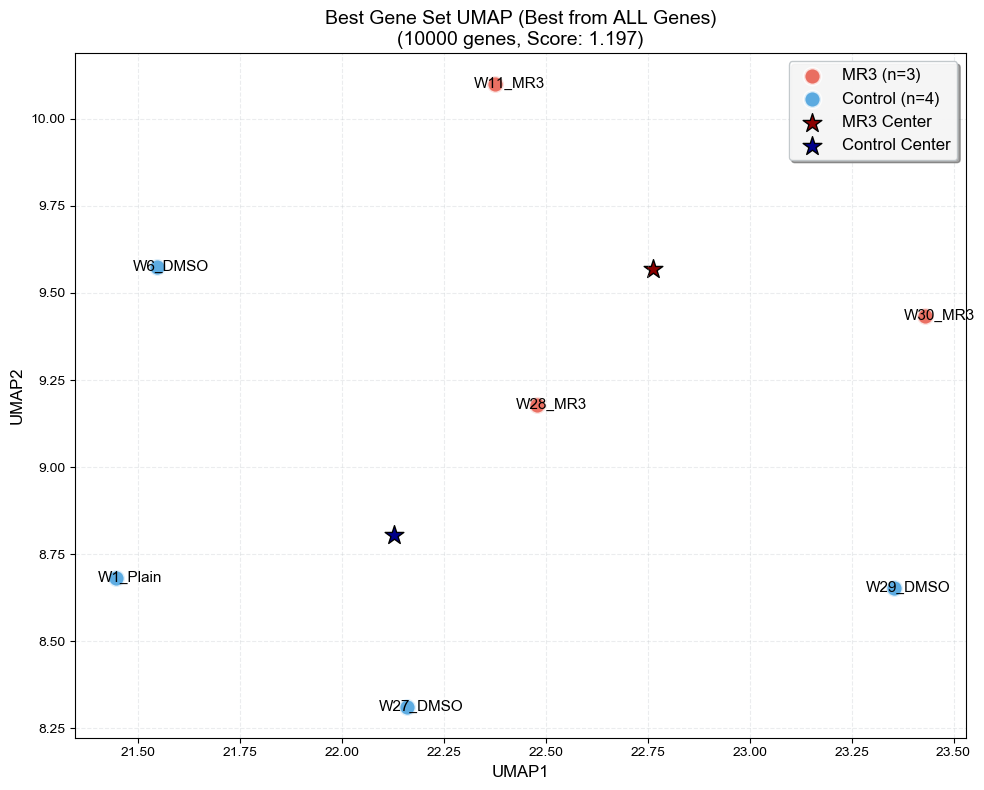

UMAP Evaluation Results:
Score: 1.1967
MR3 vs Control separation distance: 0.9940
MR3 intra-group variance: 0.3762
Control intra-group variance: 0.7956
Silhouette score: 0.1076


{'embedding': array([[22.375875, 10.099462],
        [23.430546,  9.432831],
        [22.478918,  9.178408],
        [21.547138,  9.575793],
        [22.16087 ,  8.312024],
        [23.3537  ,  8.653662],
        [21.44517 ,  8.680603]], dtype=float32),
 'mr3_indices': [0, 1, 2],
 'control_indices': [3, 4, 5, 6],
 'mr3_center': array([22.76178 ,  9.570233], dtype=float32),
 'control_center': array([22.126719,  8.805521], dtype=float32),
 'silhouette': 0.10758955,
 'mr3_intra_variance': 0.37622342,
 'control_intra_variance': 0.7956495,
 'group_separation_dist': 0.99402606,
 'score': 1.1966772470838238}

In [9]:
# Visualize best gene set results (selected from ALL genes)
print("=== Best Gene Set Visualization (Selected from ALL Genes) ===")
print(f"Visualizing best gene set of {len(best_genes)} genes selected from ALL {len(selector.common_genes)} common genes")
visualize_results(selector, best_genes, title_suffix="(Best from ALL Genes)")

In [10]:
def visualize_pca_results(selector, gene_set, title_suffix=""):
    """Visualize PCA results with clean and simple format - matching the provided format"""
    # Prepare data
    data_subset = selector.all_data[gene_set]
    data_scaled = selector.scaler.fit_transform(data_subset)
    
    # Get MR3 and Control sample indices
    mr3_indices = list(range(len(selector.mr3_data)))
    control_indices = list(range(len(selector.mr3_data), len(selector.all_data)))
    
    # PCA analysis
    if len(gene_set) >= 2:
        try:
            pca = PCA(n_components=2)
            embedding = pca.fit_transform(data_scaled)
            
            # Calculate group centers
            mr3_pca = embedding[mr3_indices]
            control_pca = embedding[control_indices]
            mr3_center = np.mean(mr3_pca, axis=0)
            control_center = np.mean(control_pca, axis=0)
            
            # Calculate metrics
            mr3_intra_variance = np.var(mr3_pca, axis=0).sum()
            control_intra_variance = np.var(control_pca, axis=0).sum()
            separation_pca = np.linalg.norm(mr3_center - control_center)
            score = (1 / (1 + mr3_intra_variance) + 1 / (1 + control_intra_variance)) * 0.7 + separation_pca * 0.3
            explained_variance_ratio = pca.explained_variance_ratio_
            
            # Create the result dictionary to match the format
            result_pca = {
                'embedding': embedding,
                'mr3_indices': mr3_indices,
                'control_indices': control_indices,
                'mr3_center': mr3_center,
                'control_center': control_center,
                'score': score,
                'group_separation_dist': separation_pca,
                'mr3_intra_variance': mr3_intra_variance,
                'control_intra_variance': control_intra_variance,
                'explained_variance_ratio': explained_variance_ratio
            }
            
            # Create figure
            plt.figure(figsize=(10, 8))
            
            # Plot sample points (MR3 and Control only)
            plt.scatter(embedding[mr3_indices, 0], embedding[mr3_indices, 1],
                       s=150, marker='o', edgecolor='white', linewidth=2, c='#e74c3c',
                       label=f'MR3 (n={len(mr3_indices)})', alpha=0.8)
            
            plt.scatter(embedding[control_indices, 0], embedding[control_indices, 1],
                       s=150, marker='o', edgecolor='white', linewidth=2, c='#3498db',
                       label=f'Control (n={len(control_indices)})', alpha=0.8)
            
            # Mark group centers
            plt.scatter(mr3_center[0], mr3_center[1], 
                       c='darkred', s=200, marker='*', label='MR3 Center', edgecolors='black')
            plt.scatter(control_center[0], control_center[1], 
                       c='darkblue', s=200, marker='*', label='Control Center', edgecolors='black')
            
            # Add sample labels
            mr3_sample_names = list(selector.mr3_data.index)
            control_sample_names = list(selector.control_data.index)
            
            # Sample label offsets
            mr3_offsets = {name: (10, 0) for name in mr3_sample_names}
            control_offsets = {name: (10, 0) for name in control_sample_names}
            
            for i, sample_name in enumerate(mr3_sample_names):
                idx = mr3_indices[i]
                offset = mr3_offsets.get(sample_name, (10, 0))
                plt.annotate(sample_name, (embedding[idx, 0], embedding[idx, 1]),
                           textcoords="offset points", xytext=offset, ha='center', va='center', 
                           fontsize=11, color='black', fontweight='bold')
            
            for i, sample_name in enumerate(control_sample_names):
                idx = control_indices[i]
                offset = control_offsets.get(sample_name, (10, 0))
                plt.annotate(sample_name, (embedding[idx, 0], embedding[idx, 1]),
                           textcoords="offset points", xytext=offset, ha='center', va='center', 
                           fontsize=11, color='black', fontweight='bold')
            
            # Calculate variance explained ratio
            plt.title(f'Best Gene Set PCA {title_suffix}\n({len(gene_set)} genes, Score: {result_pca["score"]:.3f})\nPC1: {explained_variance_ratio[0]:.1%}, PC2: {explained_variance_ratio[1]:.1%}', 
                      fontsize=14, fontweight='bold')
            plt.xlabel(f'PC1 ({explained_variance_ratio[0]:.1%})', fontsize=12)
            plt.ylabel(f'PC2 ({explained_variance_ratio[1]:.1%})', fontsize=12)
            plt.legend(loc='best', frameon=True, fancybox=True, shadow=True, fontsize=12, 
                      facecolor='white', edgecolor='#bdc3c7', framealpha=0.9)
            plt.grid(True, alpha=0.3, linestyle='--', color='#bdc3c7')
            plt.tight_layout()
            plt.show()
            
            print(f"Best Gene Set PCA evaluation results:")
            print(f"Score: {result_pca['score']:.4f}")
            print(f"MR3 vs Control separation distance: {result_pca['group_separation_dist']:.4f}")
            print(f"MR3 intra-group variance: {result_pca['mr3_intra_variance']:.4f}")
            print(f"Control intra-group variance: {result_pca['control_intra_variance']:.4f}")
            print(f"PC1 explained variance ratio: {explained_variance_ratio[0]:.3f}")
            print(f"PC2 explained variance ratio: {explained_variance_ratio[1]:.3f}")
            
            return result_pca
            
        except Exception as e:
            print(f'PCA computation failed: {str(e)}')
            return None
    else:
        print('Too few genes for PCA analysis')
        return None

print("Updated PCA visualization function completed!")

Updated PCA visualization function completed!


=== Best Gene Set PCA Analysis (Selected from ALL Genes) ===
PCA analysis of best gene set: 10000 genes selected from ALL 23729 common genes


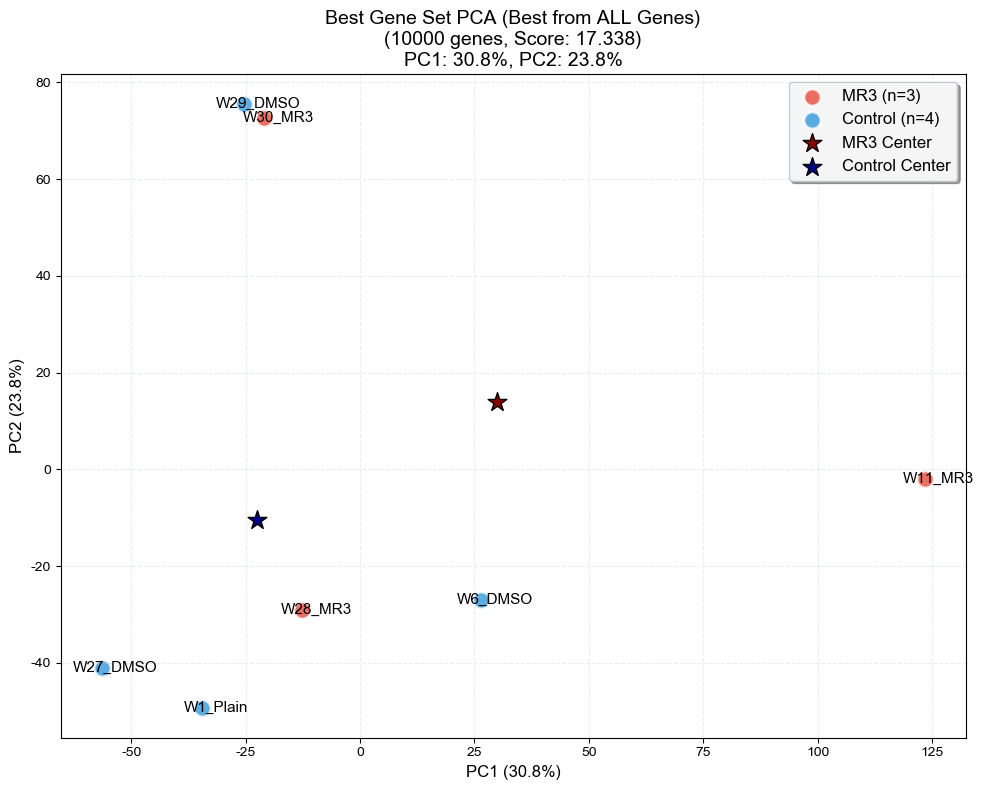

Best Gene Set PCA evaluation results:
Score: 17.3379
MR3 vs Control separation distance: 57.7918
MR3 intra-group variance: 6220.0553
Control intra-group variance: 3451.5965
PC1 explained variance ratio: 0.308
PC2 explained variance ratio: 0.238


In [11]:
# Best Gene Set PCA visualization (selected from ALL genes)
print("=== Best Gene Set PCA Analysis (Selected from ALL Genes) ===")
print(f"PCA analysis of best gene set: {len(best_genes)} genes selected from ALL {len(selector.common_genes)} common genes")
result_best_pca = visualize_pca_results(selector, best_genes, title_suffix="(Best from ALL Genes)")